In [2]:
#%%导入包

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import shap
import sklearn
#（边缘包）
import warnings
import streamlit as st
import pickle
import json

####（边缘函数）
from numpy import argmax
from functools import reduce
from io import StringIO
from collections import Counter
from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler

###
from sklearn import svm, datasets,tree,linear_model,metrics
from sklearn.preprocessing import StandardScaler,label_binarize,OrdinalEncoder
from sklearn.ensemble import VotingClassifier,ExtraTreesClassifier,RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay,roc_auc_score,accuracy_score,roc_auc_score, roc_curve, auc,f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold,KFold,cross_val_score,train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification,fetch_openml

###
import xgboost
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

%matplotlib inline
sns.set(style="darkgrid") #设置seaborn为暗黑风格

## 一、堆叠模型

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
random_state_new = 50
jc = 10

In [4]:
import pandas as pd  
  
df = pd.read_csv('/home/gg/jupyter_notebook_wd/Radiomice/Untitled Folder/三合一.csv')  


#df1 = pd.read_csv('(PRJNA375935)~97+114.txt', sep='\t')
#df2 = pd.read_csv('(PRJEB28545)~113+37.txt', sep='\t')

In [5]:
# 定义目标列
target = 'survival'

# 传统影像指标
X_trad = df.iloc[:, 19:25]
y = df[target]
X_train_trad, X_test_trad, y_train, y_test = train_test_split(X_trad, y, test_size=0.2, random_state=42)

model_trad = LogisticRegression(random_state=50)
# model_trad =MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs',
#                     alpha=0.0001,
#                     batch_size='auto',
#                     learning_rate='constant',
#                     learning_rate_init=1,
#                     power_t=0.5,
#                     max_iter=200,
#                     shuffle=True, random_state=random_state_new)
model_trad.fit(X_train_trad, y_train)

# 深度学习影像指标
X_deep = df.iloc[:, 25:28]
X_train_deep, X_test_deep, y_train, y_test = train_test_split(X_deep, y, test_size=0.2, random_state=42)

model_deep = LogisticRegression(random_state=50)
# model_deep =GaussianNB(var_smoothing=1e-1)
model_deep.fit(X_train_deep, y_train)

# 临床指标
features_clinical = ["Age", "ALP", "Monocyte", "Neutrophil", "MLR"] 
X_clinical = df[features_clinical]
X_train_clinical, X_test_clinical, y_train, y_test = train_test_split(X_clinical, y, test_size=0.2, random_state=42)

model_clinical = LogisticRegression(random_state=50)
# model_clinical =BaggingClassifier(KNeighborsClassifier(),
#                         max_samples=0.5, max_features=0.5, random_state=random_state_new)
model_clinical.fit(X_train_clinical, y_train)


/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=50)

In [6]:
# 定义堆叠模型
estimators = [
    ('trad', model_trad),
    ('deep', model_deep),
    ('clinical', model_clinical)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42)
)

# 数据预处理，合并不同特征集作为输入
X_combined_train = pd.concat([X_train_trad, X_train_deep, X_train_clinical], axis=1)
X_combined_test = pd.concat([X_test_trad, X_test_deep, X_test_clinical], axis=1)

# 训练堆叠模型
stacking_model.fit(X_combined_train, y_train)

# 获取训练集和测试集的预测概率
y_train_pred_proba = stacking_model.predict_proba(X_combined_train)[:, 1]
y_test_pred_proba = stacking_model.predict_proba(X_combined_test)[:, 1]

# 获取训练集和测试集的类别预测
y_train_pred = stacking_model.predict(X_combined_train)
y_test_pred = stacking_model.predict(X_combined_test)

### 计算模型在测试集中的各参数结果 ####
# 计算 F1 值
F1 = f1_score(y_test, y_test_pred, average='weighted')  # 可根据数据调整为 'weighted'

# 计算 AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
AUC = auc(fpr, tpr)

# 计算准确率
accuracy = accuracy_score(y_test, y_test_pred)

# 计算敏感性和特异性
TN, FP, FN, TP = confusion_matrix(y_test, y_test_pred).ravel()
sensitivity = round(TP / (TP + FN), 3)
specificity = round(TN / (TN + FP), 3)

# 输出结果
print(f'Stacking Model F1 Score: {F1:.4f}')
print(f'Stacking Model AUC: {AUC:.4f}')
print(f'Stacking Model Accuracy: {accuracy:.4f}')
print(f'Stacking Model Sensitivity: {sensitivity:.4f}')
print(f'Stacking Model Specificity: {specificity:.4f}')

# 将结果存入字典或列表中（如与其他模型的结果做对比）
stacking_model_metrics = {
    'F1': F1,
    'AUC': AUC,
    'Accuracy': accuracy,
    'Sensitivity': sensitivity,
    'Specificity': specificity
}



/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Stacking Model F1 Score: 0.7288
Stacking Model AUC: 0.7802
Stacking Model Accuracy: 0.7500
Stacking Model Sensitivity: 0.4290
Stacking Model Specificity: 0.9230


/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

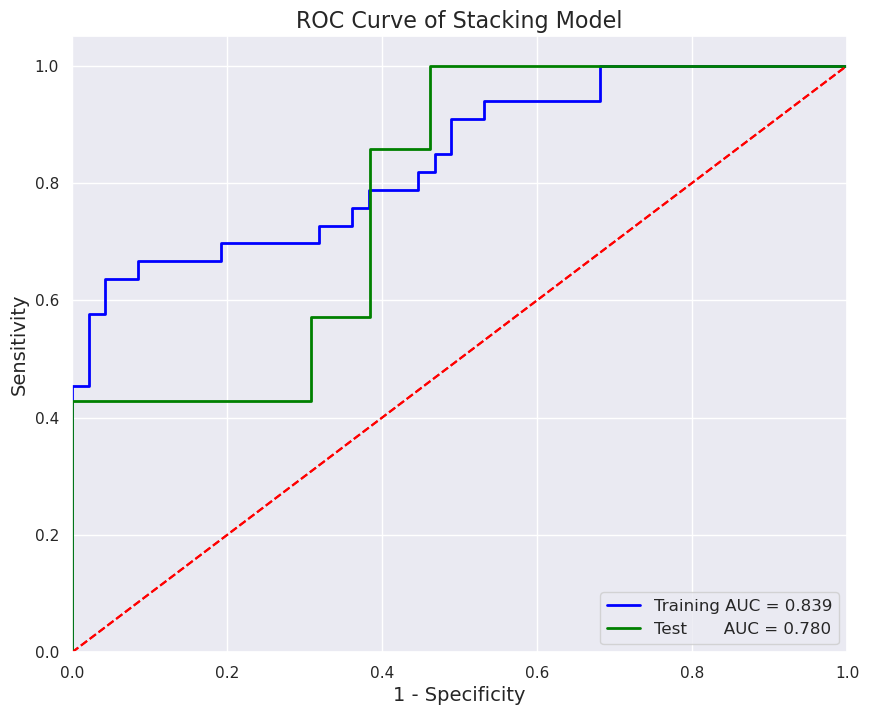

In [7]:
# 定义绘制ROC曲线的函数
def plot_roc_curve(y_true, y_score, title, color, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2, 
             label='%s AUC = %0.3f' % (classifier_name, roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    
# 开始绘制
sns.set()
# sns.set(style='whitegrid')
plt.figure(figsize=(10, 8))

# 绘制训练集ROC曲线
plot_roc_curve(y_train, y_train_pred_proba, 
               title='ROC Curve of Stacking Model', 
               color='blue', classifier_name='Training')

# 绘制测试集ROC曲线
plot_roc_curve(y_test, y_test_pred_proba, 
               title='ROC Curve of Stacking Model', 
               color='green', classifier_name='Test      ')

# 显示图像
plt.savefig('ROC Curve of Stacking Model.pdf', format='pdf')
plt.show()

## 二、投票加权模型

In [8]:
import pandas as pd
df = pd.read_csv('/home/gg/jupyter_notebook_wd/Radiomice/Untitled Folder/三合一.csv')  

### 1.网格搜索在验证集中寻找最佳权重

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, accuracy_score, confusion_matrix

# 定义目标列
target = 'survival'

# 传统影像指标
X_trad = df.iloc[:, 19:25]
y = df[target]
X_train_trad, X_test_trad, y_train, y_test = train_test_split(X_trad, y, test_size=0.2, random_state=42)

model_trad = LogisticRegression(random_state=50)
# model_trad =MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs',
#                     alpha=0.0001,
#                     batch_size='auto',
#                     learning_rate='constant',
#                     learning_rate_init=1,
#                     power_t=0.5,
#                     max_iter=200,
#                     shuffle=True, random_state=random_state_new)
model_trad.fit(X_train_trad, y_train)

# 深度学习影像指标
X_deep = df.iloc[:, 25:28]
X_train_deep, X_test_deep, y_train, y_test = train_test_split(X_deep, y, test_size=0.2, random_state=42)

model_deep = LogisticRegression(random_state=50)
# model_deep =GaussianNB(var_smoothing=1e-1)
model_deep.fit(X_train_deep, y_train)

# 临床指标
features_clinical = ["Age", "ALP", "Monocyte", "Neutrophil", "MLR"] 
X_clinical = df[features_clinical]
X_train_clinical, X_test_clinical, y_train, y_test = train_test_split(X_clinical, y, test_size=0.2, random_state=42)

model_clinical = LogisticRegression(random_state=50)
# model_clinical =BaggingClassifier(KNeighborsClassifier(),
#                         max_samples=0.5, max_features=0.5, random_state=random_state_new)
model_clinical.fit(X_train_clinical, y_train)


/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=50)

In [10]:
# 划分训练集和验证集
X_train_trad_sub, X_val_trad, y_train_sub, y_val = train_test_split(X_train_trad, y_train, test_size=0.2, random_state=42)
X_train_deep_sub, X_val_deep, _, _ = train_test_split(X_train_deep, y_train, test_size=0.2, random_state=42)
X_train_clinical_sub, X_val_clinical, _, _ = train_test_split(X_train_clinical, y_train, test_size=0.2, random_state=42)

# 获取每个模型在验证集上的预测概率
proba_trad_val = model_trad.predict_proba(X_val_trad)
proba_deep_val = model_deep.predict_proba(X_val_deep)
proba_clinical_val = model_clinical.predict_proba(X_val_clinical)

# 定义搜索空间
weight_range = np.arange(0.0, 1.1, 0.1)

# 保存AUC得分
auc_scores = []

# 网格搜索
for w_trad in weight_range:
    for w_deep in weight_range:
        w_clinical = 1.0 - w_trad - w_deep  # 确保总权重为1
        if w_clinical < 0 or w_clinical > 1:  # 保证权重有效性
            continue
        
        # 计算验证集的加权平均概率
        weighted_proba_val = (w_trad * proba_trad_val[:, 1] + 
                              w_deep * proba_deep_val[:, 1] + 
                              w_clinical * proba_clinical_val[:, 1])
        
        # 计算验证集AUC
        auc_val = roc_auc_score(y_val, weighted_proba_val)
        auc_scores.append((w_trad, w_deep, w_clinical, auc_val))

# 将结果转换为数组
auc_scores = np.array(auc_scores)

# 找到最佳权重组合
best_idx = np.argmax(auc_scores[:, 3])
best_weights = auc_scores[best_idx, :3]
best_auc = auc_scores[best_idx, 3]

print(f'最佳权重组合: 传统影像: {best_weights[0]:.2f}, 深度影像: {best_weights[1]:.2f}, 临床特征: {best_weights[2]:.2f}')
print(f'最佳AUC (验证集): {best_auc:.4f}')



最佳权重组合: 传统影像: 0.60, 深度影像: 0.30, 临床特征: 0.10
最佳AUC (验证集): 0.8000


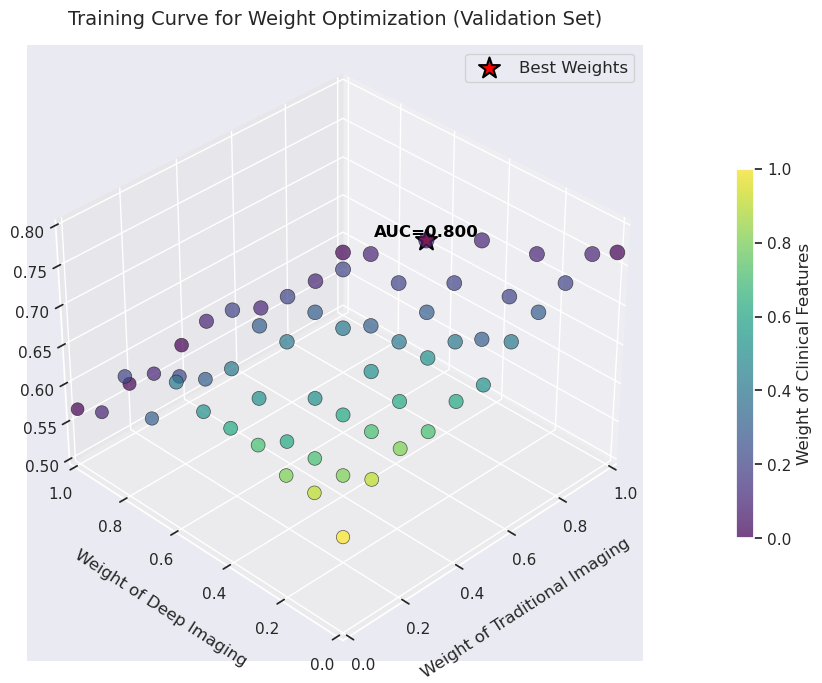

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 假设数据已经存储在变量中
# auc_scores: (N, 4) 形状的数组, 列分别对应 传统影像权重、深度影像权重、临床特征权重、AUC值
# best_weights: (2,) 形状的数组, 对应最佳权重 (传统影像, 深度影像)
# best_auc: 最佳 AUC 值

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 设定视角，使曲线更加直观
ax.view_init(elev=35, azim=225)

# 设定坐标轴范围
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0.5, 0.8)  # 根据 AUC 取值范围调整

# 3D 散点图: 颜色代表临床特征权重，点大小代表 AUC
sc = ax.scatter(
    auc_scores[:, 0], auc_scores[:, 1], auc_scores[:, 3], 
    c=auc_scores[:, 2], s=auc_scores[:, 3] * 150,  # 放大点的大小
    cmap='viridis', alpha=0.7, edgecolors='k', linewidths=0.5
)

# 标出最佳权重组合点
ax.scatter(
    best_weights[0], best_weights[1], best_auc, 
    color='red', s=250, edgecolor='black', linewidth=1.5, label='Best Weights', marker='*'
)

# 添加最佳点的文本标注
ax.text(
    best_weights[0], best_weights[1], best_auc + 0.005, 
    f'AUC={best_auc:.3f}', color='black', fontsize=12, fontweight='bold', ha='center'
)

# 设置坐标轴标签
ax.set_xlabel('Weight of Traditional Imaging', fontsize=12, labelpad=12)
ax.set_ylabel('Weight of Deep Imaging', fontsize=12, labelpad=12)
ax.set_zlabel('AUC', fontsize=12, labelpad=12)

# 添加标题
ax.set_title('Training Curve for Weight Optimization (Validation Set)', fontsize=14, pad=15)

# 添加颜色条，显示临床特征权重
cbar = plt.colorbar(sc, shrink=0.6, aspect=20, pad=0.1)
cbar.set_label('Weight of Clinical Features', fontsize=12)

# 添加图例
ax.legend(loc='upper right', fontsize=12)

# 保存图片
plt.savefig('Training_Curve_Weight_Optimization.pdf', format='pdf', bbox_inches='tight', dpi=300)

# 显示图形
plt.show()


### 2.最佳权重在训练集中评估

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, accuracy_score, confusion_matrix

# 使用最佳权重组合在训练集上进行评估
proba_trad_train = model_trad.predict_proba(X_train_trad)
proba_deep_train = model_deep.predict_proba(X_train_deep)
proba_clinical_train = model_clinical.predict_proba(X_train_clinical)

weighted_proba_train = (best_weights[0] * proba_trad_train[:, 1] +
                        best_weights[1] * proba_deep_train[:, 1] +
                        best_weights[2] * proba_clinical_train[:, 1])

# 计算训练集的各项指标
y_pred_train = (weighted_proba_train > 0.4).astype(int)

F1_train = f1_score(y_train, y_pred_train, average='macro')
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, weighted_proba_train)
AUC_train = auc(fpr_train, tpr_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
TN_train, FP_train, FN_train, TP_train = confusion_matrix(y_train, y_pred_train).ravel()
sensitivity_train = round(TP_train / (TP_train + FN_train), 3)
specificity_train = round(TN_train / (TN_train + FP_train), 3)

# 输出训练集结果
print(f'Training Set Weighted Voting F1 Score: {F1_train:.4f}')
print(f'Training Set Weighted Voting AUC: {AUC_train:.4f}')
print(f'Training Set Weighted Voting Accuracy: {accuracy_train:.4f}')
print(f'Training Set Weighted Voting Sensitivity: {sensitivity_train:.4f}')
print(f'Training Set Weighted Voting Specificity: {specificity_train:.4f}')


Training Set Weighted Voting F1 Score: 0.7538
Training Set Weighted Voting AUC: 0.8053
Training Set Weighted Voting Accuracy: 0.7625
Training Set Weighted Voting Sensitivity: 0.6970
Training Set Weighted Voting Specificity: 0.8090


### 3.最佳权重在测试集中评估

In [13]:
# 使用最佳权重组合在测试集上进行评估
proba_trad_test = model_trad.predict_proba(X_test_trad)
proba_deep_test = model_deep.predict_proba(X_test_deep)
proba_clinical_test = model_clinical.predict_proba(X_test_clinical)

weighted_proba_test = (best_weights[0] * proba_trad_test[:, 1] +
                       best_weights[1] * proba_deep_test[:, 1] +
                       best_weights[2] * proba_clinical_test[:, 1])

# 计算测试集的各项指标
y_pred_test = (weighted_proba_test > 0.4).astype(int)

F1 = f1_score(y_test, y_pred_test, average='macro')
fpr, tpr, thresholds = roc_curve(y_test, weighted_proba_test)
AUC = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_pred_test)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred_test).ravel()
sensitivity = round(TP / (TP + FN), 3)
specificity = round(TN / (TN + FP), 3)

# 输出结果
print(f'Final Weighted Voting F1 Score: {F1:.4f}')
print(f'Final Weighted Voting AUC: {AUC:.4f}')
print(f'Final Weighted Voting Accuracy: {accuracy:.4f}')
print(f'Final Weighted Voting Sensitivity: {sensitivity:.4f}')
print(f'Final Weighted Voting Specificity: {specificity:.4f}')

Final Weighted Voting F1 Score: 0.8810
Final Weighted Voting AUC: 0.9560
Final Weighted Voting Accuracy: 0.9000
Final Weighted Voting Sensitivity: 0.7140
Final Weighted Voting Specificity: 1.0000


# 三 绘图

## 1.ROC曲线

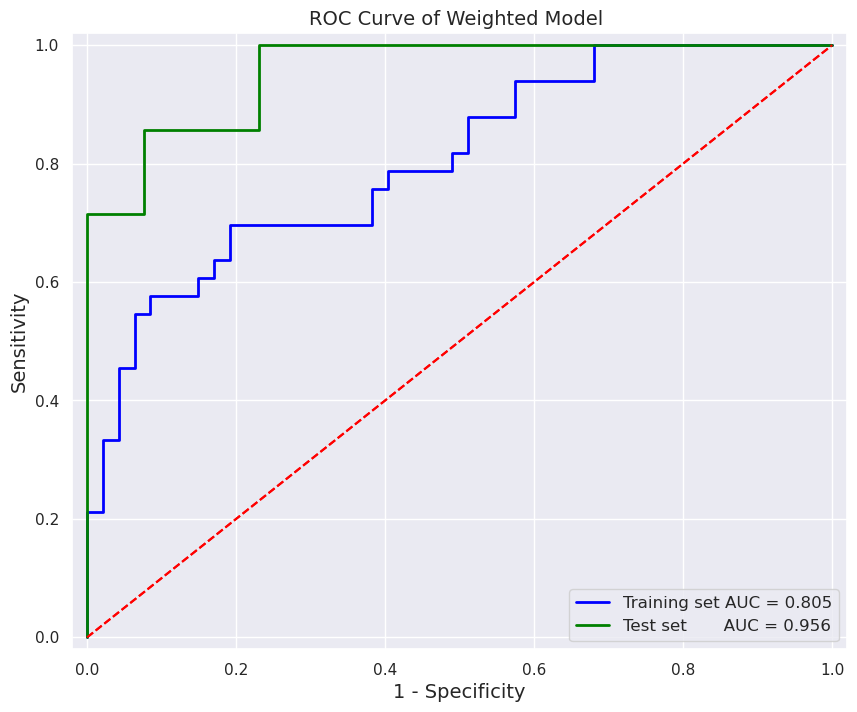

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 定义一个函数来绘制ROC曲线
def plot_roc_curve(k, y_true, y_score, title, classifier_name, color):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(k)
    plt.title(title, fontsize=14)
    plt.plot(fpr, tpr, color=color, lw=2, label='%s AUC = %0.3f' % (classifier_name, roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)

# 训练集的加权概率
y_pred_train_proba = (best_weights[0] * proba_trad_train[:, 1] + 
                      best_weights[1] * proba_deep_train[:, 1] + 
                      best_weights[2] * proba_clinical_train[:, 1])

# 验证集的加权概率
y_pred_test_proba = (best_weights[0] * proba_trad_test[:, 1] + 
                     best_weights[1] * proba_deep_test[:, 1] + 
                     best_weights[2] * proba_clinical_test[:, 1])
sns.set()
plt.figure(figsize=(10, 8))
# 绘制训练集的ROC曲线
plot_roc_curve(1, y_train, y_pred_train_proba, "ROC Curve of Weighted Model ", "Training set", 'blue') #使用相同的编号 1，将训练集和验证集的ROC曲线绘制在同一张图中
# 绘制验证集的ROC曲线
plot_roc_curve(1, y_test, y_pred_test_proba, "ROC Curve of Weighted Model ", "Test set      ", 'green')

# 显示图形
plt.savefig('ROC Curve of Weighted Model.pdf',format='pdf')
plt.show()


## 2. PR曲线绘制

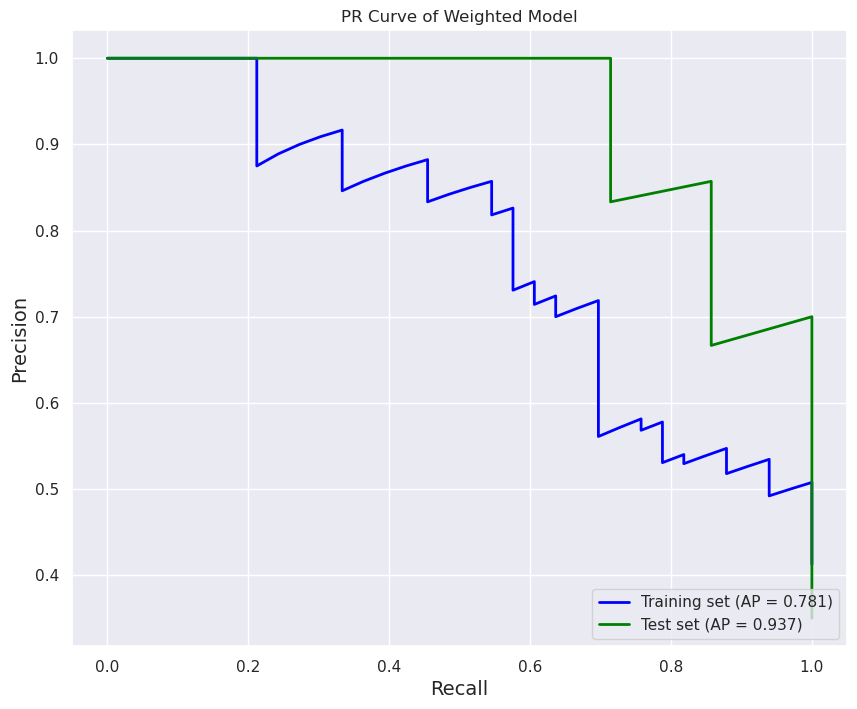

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# 定义一个函数来绘制PR曲线
def plot_pr_curve(k, y_true, y_score, title, method_name, color):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    
    plt.figure(k)
    plt.plot(recall, precision, lw=2, label=f'{method_name} (AP = {ap_score:.3f})', color=color)
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)

# 训练集的加权概率
y_pred_train_proba = (best_weights[0] * proba_trad_train[:, 1] + 
                      best_weights[1] * proba_deep_train[:, 1] + 
                      best_weights[2] * proba_clinical_train[:, 1])

# 验证集的加权概率
y_pred_test_proba = (best_weights[0] * proba_trad_test[:, 1] + 
                     best_weights[1] * proba_deep_test[:, 1] + 
                     best_weights[2] * proba_clinical_test[:, 1])

sns.set()
plt.figure(figsize=(10, 8))
# 绘制训练集的PR曲线
plot_pr_curve(1, y_train, y_pred_train_proba, "PR Curve of Weighted Model", "Training set", 'blue')

# 绘制测试集的PR曲线
plot_pr_curve(1, y_test, y_pred_test_proba, "PR Curve of Weighted Model", "Test set", 'green')

# 显示图形
plt.savefig('PR Curve of Weighted Model.pdf',format='pdf')
plt.show()


## 3.校准曲线

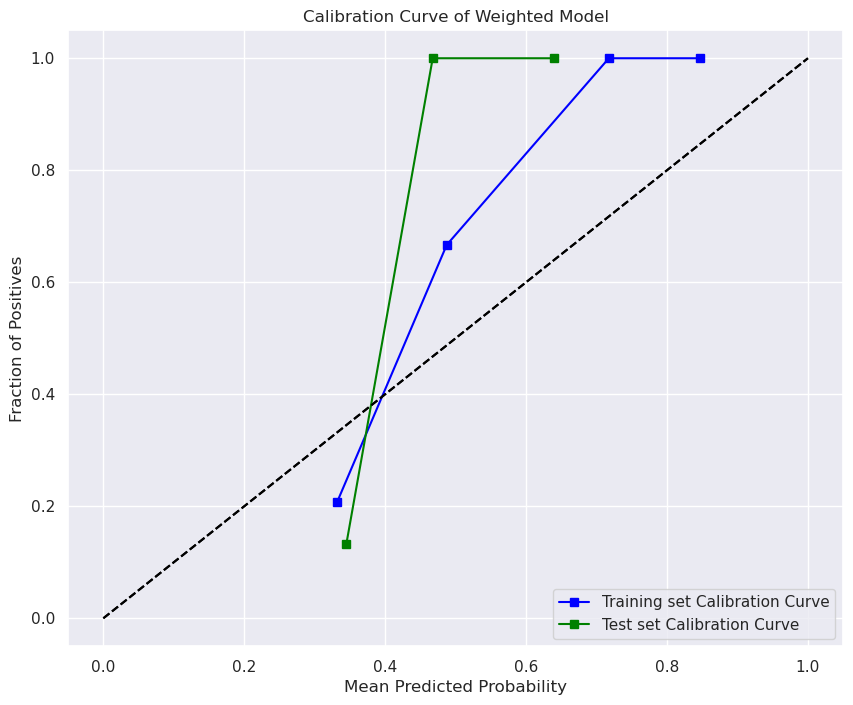

In [16]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# 定义一个函数来绘制校准曲线
def plot_calibration_curve(k, y_true, y_pred, title, method_name, color):
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=5)
    plt.figure(k)
    plt.plot(prob_pred, prob_true, color=color, label=f'{method_name} Calibration Curve', marker='s')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # 完美校准线
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)

# 训练集的加权概率
y_pred_train_proba = (best_weights[0] * proba_trad_train[:, 1] + 
                      best_weights[1] * proba_deep_train[:, 1] + 
                      best_weights[2] * proba_clinical_train[:, 1])

# 验证集的加权概率
y_pred_test_proba = (best_weights[0] * proba_trad_test[:, 1] + 
                     best_weights[1] * proba_deep_test[:, 1] + 
                     best_weights[2] * proba_clinical_test[:, 1])

sns.set()
plt.figure(figsize=(10, 8))
# 绘制训练集的校准曲线
plot_calibration_curve(1, y_train, y_pred_train_proba, "Calibration Curve of Weighted Model", "Training set", 'blue')

# 绘制测试集的校准曲线
plot_calibration_curve(1, y_test, y_pred_test_proba, "Calibration Curve of Weighted Model", "Test set", 'green')

# 显示图形
plt.show()


## 4.混淆矩阵

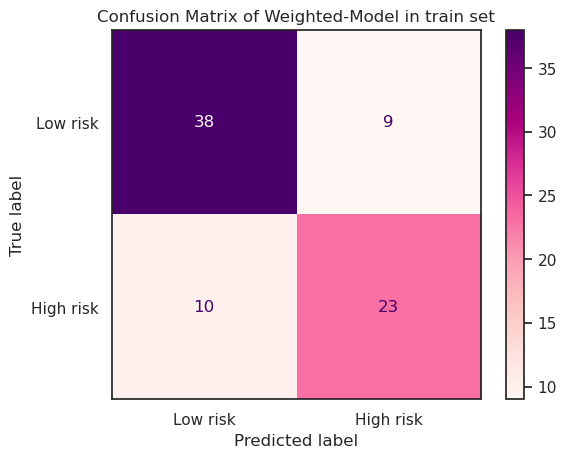

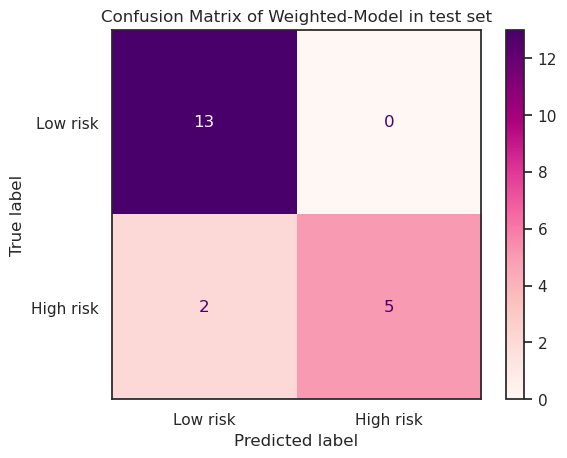

In [17]:
# 训练集的加权概率
y_pred_train_proba = (best_weights[0] * proba_trad_train[:, 1] + 
                      best_weights[1] * proba_deep_train[:, 1] + 
                      best_weights[2] * proba_clinical_train[:, 1])
y_pred_train = (y_pred_train_proba > 0.4).astype(int)

# 验证集的加权概率
y_pred_test_proba = (best_weights[0] * proba_trad_test[:, 1] + 
                     best_weights[1] * proba_deep_test[:, 1] + 
                     best_weights[2] * proba_clinical_test[:, 1]) 
y_pred_test = (y_pred_test_proba > 0.4).astype(int)
  
# 创建一个图形和两个子图  
#训练集
# plt.subplot(1,2,1)
mlp_prob_train = y_pred_train  
cm = confusion_matrix(y_train, mlp_prob_train)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low risk', 'High risk'])  
sns.set_style("white")  
disp.plot(cmap='RdPu') 
plt.title("Confusion Matrix of Weighted-Model in train set")
plt.savefig('训练集混淆矩阵.pdf',format='pdf')
plt.show()

#测试集
# plt.subplot(1,2,2)
mlp_prob_test = y_pred_test
cm = confusion_matrix(y_test, mlp_prob_test)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low risk', 'High risk'])  
sns.set_style("white")  
disp.plot(cmap='RdPu') 
plt.title("Confusion Matrix of Weighted-Model in test set")  
plt.savefig('测试集混淆矩阵.pdf',format='pdf') 
plt.show()

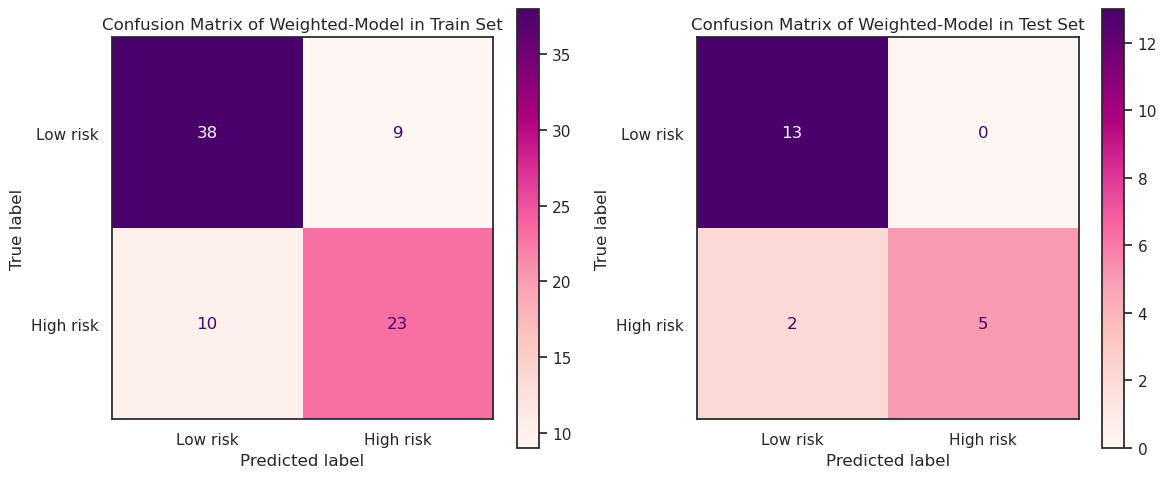

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 计算训练集加权概率
y_pred_train_proba = (best_weights[0] * proba_trad_train[:, 1] + 
                      best_weights[1] * proba_deep_train[:, 1] + 
                      best_weights[2] * proba_clinical_train[:, 1])
y_pred_train = (y_pred_train_proba > 0.4).astype(int)

# 计算测试集加权概率
y_pred_test_proba = (best_weights[0] * proba_trad_test[:, 1] + 
                     best_weights[1] * proba_deep_test[:, 1] + 
                     best_weights[2] * proba_clinical_test[:, 1]) 
y_pred_test = (y_pred_test_proba > 0.4).astype(int)

# 设置画布和子图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列，调整大小

# 训练集混淆矩阵
cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Low risk', 'High risk'])
sns.set_style("white")
disp_train.plot(cmap='RdPu', ax=axes[0])
axes[0].set_title("Confusion Matrix of Weighted-Model in Train Set")

# 测试集混淆矩阵
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Low risk', 'High risk'])
disp_test.plot(cmap='RdPu', ax=axes[1])
axes[1].set_title("Confusion Matrix of Weighted-Model in Test Set")

# 调整布局，防止重叠
plt.tight_layout()

# 保存并显示
plt.savefig('训练集与测试集混淆矩阵.pdf', format='pdf')
plt.show()


## 5.五折交叉验证

/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

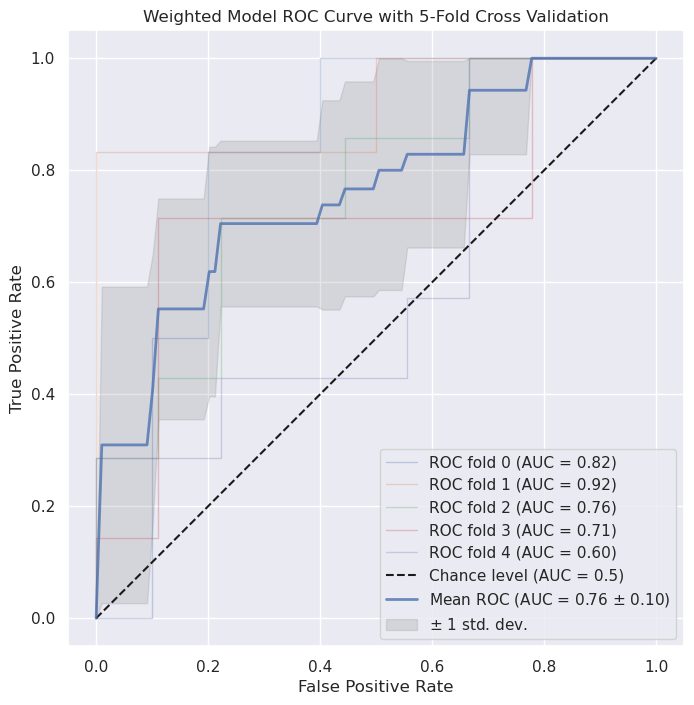

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 初始化
sns.set()
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# 替换为训练集的输入数据和标签
X_trad = X_train_trad.values
X_deep = X_train_deep.values
X_clinical = X_train_clinical.values
y = y_train.values

# 初始化图形
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)

for fold, (train_idx, test_idx) in enumerate(cv.split(X_trad, y)):
    # 获取每折的训练集和测试集
    X_train_trad_fold, X_test_trad_fold = X_trad[train_idx], X_trad[test_idx]
    X_train_deep_fold, X_test_deep_fold = X_deep[train_idx], X_deep[test_idx]
    X_train_clinical_fold, X_test_clinical_fold = X_clinical[train_idx], X_clinical[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    # 训练每个模型
    model_trad.fit(X_train_trad_fold, y_train_fold)
    model_deep.fit(X_train_deep_fold, y_train_fold)
    model_clinical.fit(X_train_clinical_fold, y_train_fold)

    # 获取预测概率
    proba_trad_fold = model_trad.predict_proba(X_test_trad_fold)[:, 1]
    proba_deep_fold = model_deep.predict_proba(X_test_deep_fold)[:, 1]
    proba_clinical_fold = model_clinical.predict_proba(X_test_clinical_fold)[:, 1]

    # 计算加权平均概率
    weighted_proba_fold = (best_weights[0] * proba_trad_fold +
                           best_weights[1] * proba_deep_fold +
                           best_weights[2] * proba_clinical_fold)

    # 绘制ROC曲线
    viz = RocCurveDisplay.from_predictions(
        y_test_fold,
        weighted_proba_fold,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    
    # 插值TPR
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# 计算平均ROC曲线
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# 绘制平均ROC曲线
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

# 绘制标准差区域
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

# 设置图形属性
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Weighted Model ROC Curve with 5-Fold Cross Validation",
)
ax.legend(loc="lower right")

# 显示图形
plt.savefig('Weighted_Model_ROC_Curve_Cross_Validation.pdf', format='pdf')
plt.show()


## 6.雷达图

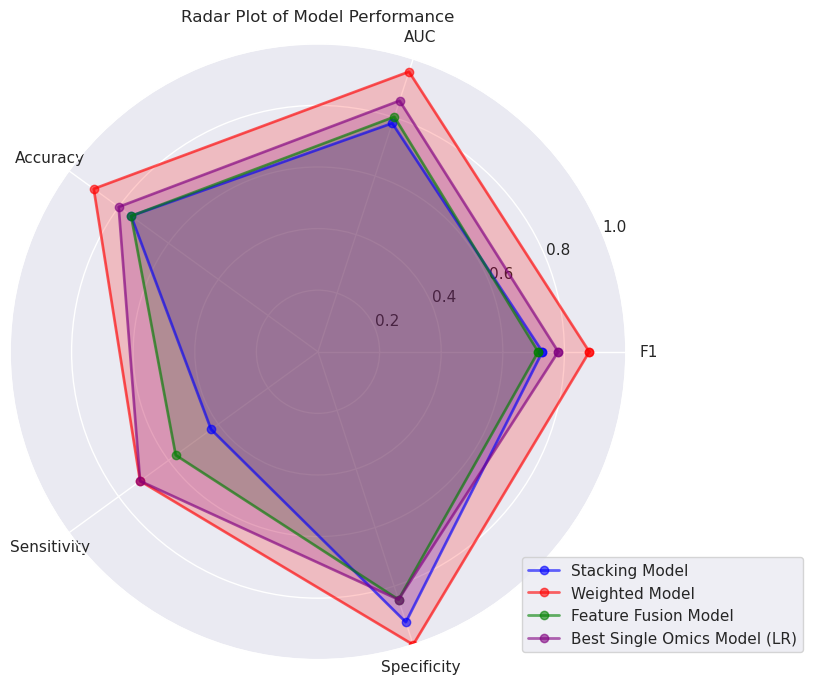

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 定义指标标签
S_labels = ['F1', 'AUC', 'Accuracy', 'Sensitivity', 'Specificity']

# 各模型的性能指标
Stacking_Model = [0.7288, 0.7802, 0.7500, 0.4290, 0.9230]
Weighted_Model = [0.8810, 0.9560, 0.9000, 0.7140, 1.0000]
Feature_fusion_model = [0.715, 0.802, 0.75, 0.571, 0.846]
LR_Model = [0.780, 0.857, 0.80, 0.714, 0.846]  # LR（最佳单组学模型）

# 让数据闭合，以便形成完整的雷达图
Stacking_Model = np.concatenate((Stacking_Model, [Stacking_Model[0]]))
Weighted_Model = np.concatenate((Weighted_Model, [Weighted_Model[0]]))
Feature_fusion_model = np.concatenate((Feature_fusion_model, [Feature_fusion_model[0]]))
LR_Model = np.concatenate((LR_Model, [LR_Model[0]]))

# 计算每个指标的角度
angles = np.linspace(0, 2 * np.pi, len(S_labels), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # 使图形闭合

# 创建雷达图
fig = plt.figure(figsize=(8, 8))  # 设置画布大小
ax = fig.add_subplot(111, polar=True)

# 绘制 Stacking Model
ax.plot(angles, Stacking_Model, 'o-', linewidth=2, alpha=0.6, label='Stacking Model', color='blue')
ax.fill(angles, Stacking_Model, alpha=0.2, color='blue')

# 绘制 Weighted Model
ax.plot(angles, Weighted_Model, 'o-', linewidth=2, alpha=0.6, label='Weighted Model', color='red')
ax.fill(angles, Weighted_Model, alpha=0.2, color='red')

# 绘制 Feature Fusion Model
ax.plot(angles, Feature_fusion_model, 'o-', linewidth=2, alpha=0.6, label='Feature Fusion Model', color='green')
ax.fill(angles, Feature_fusion_model, alpha=0.2, color='green')

# 绘制 LR Model（最佳单组学模型）
ax.plot(angles, LR_Model, 'o-', linewidth=2, alpha=0.6, label='Best Single Omics Model (LR)', color='purple')
ax.fill(angles, LR_Model, alpha=0.2, color='purple')

# 设置雷达图的指标标签
ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels=S_labels)

# 设置雷达图刻度范围
ax.set_ylim(0, 1)
ax.grid(True)

# 添加标题
plt.title('Radar Plot of Model Performance')

# 调整图例位置，避免遮挡
#plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))  
plt.legend(loc="lower right", bbox_to_anchor=(1.3, 0))  # Adjust anchor position  

# 保存并显示图像
plt.savefig('Radar Plot of Model Performance.pdf', format="pdf")
plt.show()


# 其他

In [19]:
#特征标注
features = ["Age","ALP","Monocyte","Neutrophil","MLR" ]+df.iloc[:, 25:28].columns.tolist()
target= 'survival'
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state_new)

#处理不平衡数据（重采样）
oversample = SMOTE(random_state=random_state_new)
# oversample = ADASYN()
X_train_rs, y_train_rs = oversample.fit_resample(X_train, y_train)
X_test_rs, y_test_rs = oversample.fit_resample(X_test, y_test)
# 查看原始数据集的类别分布
print('Original dataset shape:', Counter(y_train))
# 查看生成的合成样本后的类别分布
print('Resampled dataset shape:', Counter(y_train_rs))

# X = df1.iloc[:, 2:]
# y = df1.iloc[:, 1]
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state_new)

Original dataset shape: Counter({0: 47, 1: 33})
Resampled dataset shape: Counter({0: 47, 1: 47})


In [20]:
X_train = X_train_rs
y_train  = y_train_rs

# X_test = X_test_rs
# y_test  = y_test_rs

# 构建模型

In [21]:
#LR
logis_model = LogisticRegression(random_state=random_state_new,
                                 solver='lbfgs', multi_class='multinomial')
lr_model = logis_model.fit(X_train, y_train)
lr_model_y_prob = lr_model.predict_proba(X_test)

#MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs',
                    alpha=0.0001,
                    batch_size='auto',
                    learning_rate='constant',
                    learning_rate_init=1,
                    power_t=0.5,
                    max_iter=200,
                    shuffle=True, random_state=random_state_new)
mlp_model = mlp_model.fit(X_train, y_train)
mlp_model_y_prob = mlp_model.predict_proba(X_test)

#NBC
NBC_model = GaussianNB(var_smoothing=1e-1)
#from sklearn.naive_bayes import BernoulliNB
#model = BernoulliNB()
NBC_model = NBC_model.fit(X_train, y_train)
NBC_model_y_prob = NBC_model.predict_proba(X_test)

#SVC
SVC_model = SVC(kernel='rbf',C=1.0,random_state=random_state_new,probability=True)
SVC_model = SVC_model.fit(X_train, y_train)
SVC_model_y_prob = SVC_model.predict_proba(X_test)

#XGB
xgb_model = XGBClassifier(
    n_estimators=100, max_depth=2, learning_rate=1, random_state=random_state_new)
xgb_model = xgb_model.fit(X_train, y_train)
xgb_model_y_prob = xgb_model.predict_proba(X_test)

#BAG
Bag = BaggingClassifier(KNeighborsClassifier(),
                        max_samples=0.5, max_features=0.5, random_state=random_state_new)
Bag_model = Bag.fit(X_train, y_train)
Bag_model_y_prob = Bag_model.predict_proba(X_test)

#AB
AB = AdaBoostClassifier(n_estimators=10, random_state=random_state_new)
AB_model = AB.fit(X_train, y_train)
AB_model_y_prob = AB_model.predict_proba(X_test)

#GBM
gbm = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1, max_depth=1, random_state=random_state_new)
gbm_model = gbm.fit(X_train, y_train)
gbm_model_y_prob = gbm_model.predict_proba(X_test)

#RF
RF_model = RandomForestClassifier(n_estimators=100, 
                                  random_state=random_state_new)
RF_model = RF_model.fit(X_train, y_train)
RF_model_y_prob = RF_model.predict_proba(X_test)




/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


# 训练集的十折交叉验证曲线

/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

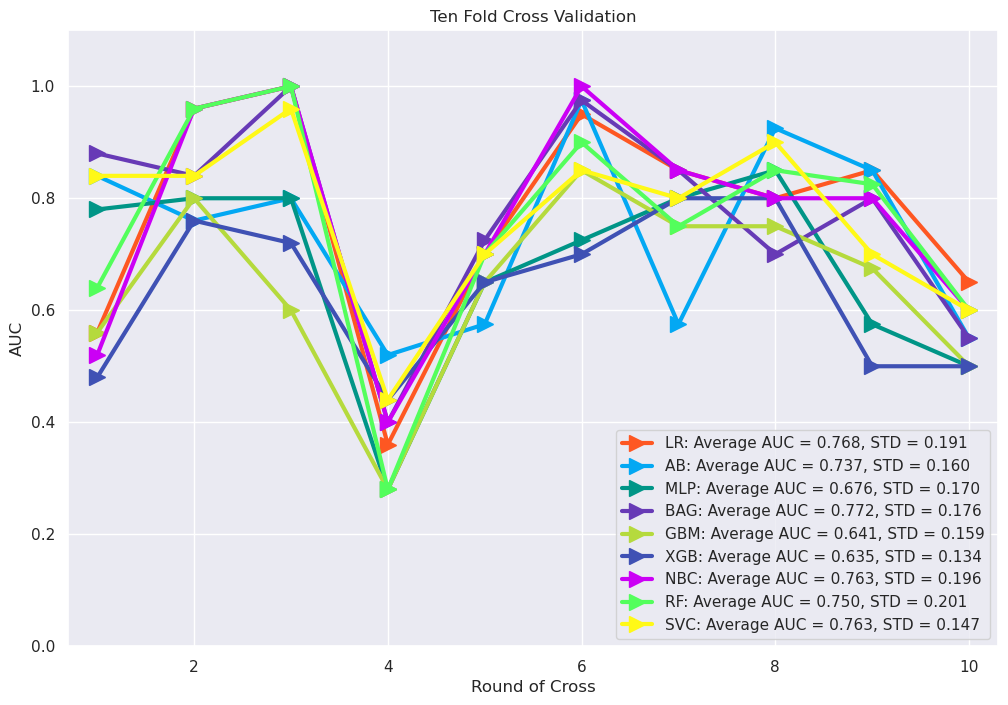

In [22]:
k_folds = 10
strKFold = StratifiedKFold(n_splits=k_folds,shuffle=True,random_state=0)#, test_size=.3)
cv=strKFold

result_lr=cross_val_score(lr_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_ab=cross_val_score(AB_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_bag=cross_val_score(Bag_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_mlp=cross_val_score(mlp_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_gbm=cross_val_score(gbm_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_xgb=cross_val_score(xgb_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)

result_nbc=cross_val_score(NBC_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_rf=cross_val_score(RF_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_svc=cross_val_score(SVC_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)

sns.set()
x = [1, 2, 3, 4, 5,6,7,8,9,10]
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
plt.plot(x, result_lr, label='LR: Average AUC = {:.3f}, STD = {:.3f}'.format(result_lr.mean(), result_lr.std()),
         linewidth=3, color='#fe5722', marker='>', markerfacecolor='#fe5722', markersize=12)
plt.plot(x, result_ab, label='AB: Average AUC = {:.3f}, STD = {:.3f}'.format(result_ab.mean(), result_ab.std()),
         linewidth=3, color='#03a8f3', marker='>', markerfacecolor='#03a8f3', markersize=12)
plt.plot(x, result_mlp, label='MLP: Average AUC = {:.3f}, STD = {:.3f}'.format(result_mlp.mean(), result_mlp.std()),
         linewidth=3, color='#009587', marker='>', markerfacecolor='#009587', markersize=12)
plt.plot(x, result_bag, label='BAG: Average AUC = {:.3f}, STD = {:.3f}'.format(result_bag.mean(), result_bag.std()),
         linewidth=3, color='#673ab6', marker='>', markerfacecolor='#673ab6', markersize=12)
plt.plot(x, result_gbm, label='GBM: Average AUC = {:.3f}, STD = {:.3f}'.format(result_gbm.mean(), result_gbm.std()),
         linewidth=3, color='#b5da3d', marker='>', markerfacecolor='#b5da3d', markersize=12)
plt.plot(x, result_xgb, label='XGB: Average AUC = {:.3f}, STD = {:.3f}'.format(result_xgb.mean(), result_xgb.std()),
         linewidth=3, color='#3f51b4', marker='>', markerfacecolor='#3f51b4', markersize=12)

plt.plot(x, result_nbc, label='NBC: Average AUC = {:.3f}, STD = {:.3f}'.format(result_nbc.mean(), result_nbc.std()),
         linewidth=3, color='#cb00f5', marker='>', markerfacecolor='#cb00f5', markersize=12)
plt.plot(x, result_rf, label='RF: Average AUC = {:.3f}, STD = {:.3f}'.format(result_rf.mean(), result_rf.std()),
         linewidth=3, color='#53fe5c', marker='>', markerfacecolor='#53fe5c', markersize=12)
plt.plot(x, result_svc, label='SVC: Average AUC = {:.3f}, STD = {:.3f}'.format(result_svc.mean(), result_svc.std()),
         linewidth=3, color='#fff917', marker='>', markerfacecolor='#fff917', markersize=12)

ax = plt.gca()
plt.ylim(0.0, 1.1)
plt.xlim(0.7, 10.3)
plt.xlabel('Round of Cross')
plt.ylabel('AUC')
plt.title('Ten Fold Cross Validation')
plt.legend(loc=4)
# plt.show()

plt.savefig("十折交叉验证.pdf",format='pdf')
plt.show()

# 训练集和测试集的ROC曲线

/tmp/ipykernel_2701433/840185635.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b',color=color,label='%s AUC = %0.3f'% (classifiers,roc_auc))
/tmp/ipykernel_2701433/840185635.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b',color=color,label='%s AUC = %0.3f'% (classifiers,roc_auc))
/tmp/ipykernel_2701433/840185635.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b',color=color,label='%s AUC = %0.3f'% (class

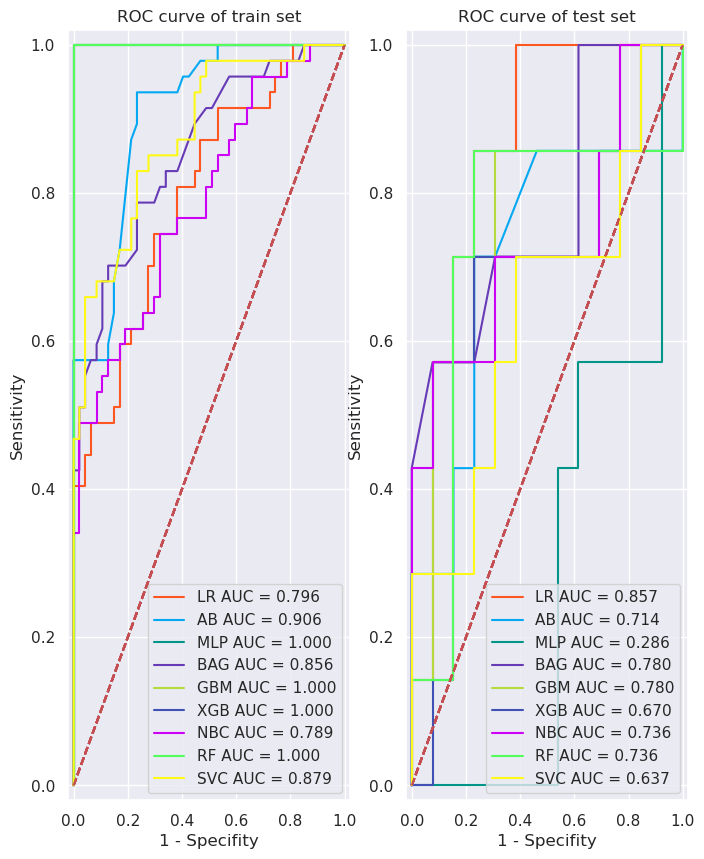

In [24]:
plt.style.use('tableau-colorblind10')
def plot_roc(k,y_pred_undersample_score,labels_test,classifiers,color,title):
    fpr, tpr, thresholds = metrics.roc_curve(labels_test.values.ravel(),y_pred_undersample_score)
    roc_auc = metrics.auc(fpr,tpr)
    fontsize = 14
    plt.figure(k)
    plt.title(title)
    plt.plot(fpr, tpr, 'b',color=color,label='%s AUC = %0.3f'% (classifiers,roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.02,1.02])
    plt.ylim([-0.02,1.02])
    plt.ylabel('Sensitivity')
    plt.xlabel('1 - Specifity')
fig = plt.gcf()

plt.rcParams["figure.figsize"] = [10,10]
# fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

plt.subplot(1,2,1)
plot_roc(1,lr_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'LR','#fe5722','ROC curve of train set')
plot_roc(1,AB_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'AB','#03a8f3','ROC curve of train set')
plot_roc(1,mlp_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'MLP','#009587','ROC curve of train set')
plot_roc(1,Bag_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'BAG','#673ab6','ROC curve of train set')
plot_roc(1,gbm_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'GBM','#b5da3d','ROC curve of train set')
plot_roc(1,xgb_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'XGB','#3f51b4','ROC curve of train set')

plot_roc(1,NBC_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'NBC','#cb00f5','ROC curve of train set')
plot_roc(1,RF_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'RF','#53fe5c','ROC curve of train set')
plot_roc(1,SVC_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'SVC','#fff917','ROC curve of train set')

plt.subplot(1,2,2)
plot_roc(1,lr_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'LR','#fe5722','ROC curve of test set')
plot_roc(1,AB_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'AB','#03a8f3','ROC curve of test set')
plot_roc(1,mlp_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'MLP','#009587','ROC curve of test set')
plot_roc(1,Bag_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'BAG','#673ab6','ROC curve of test set')
plot_roc(1,gbm_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'GBM','#b5da3d','ROC curve of test set')
plot_roc(1,xgb_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'XGB','#3f51b4','ROC curve of test set')

plot_roc(1,NBC_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'NBC','#cb00f5','ROC curve of test set')
plot_roc(1,RF_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'RF','#53fe5c','ROC curve of test set')
plot_roc(1,SVC_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'SVC','#fff917','ROC curve of test set')
# plt.show()
plt.savefig("训练集-测试集ROC曲线.pdf",format="pdf")
plt.show()

# 训练集-测试集PR曲线

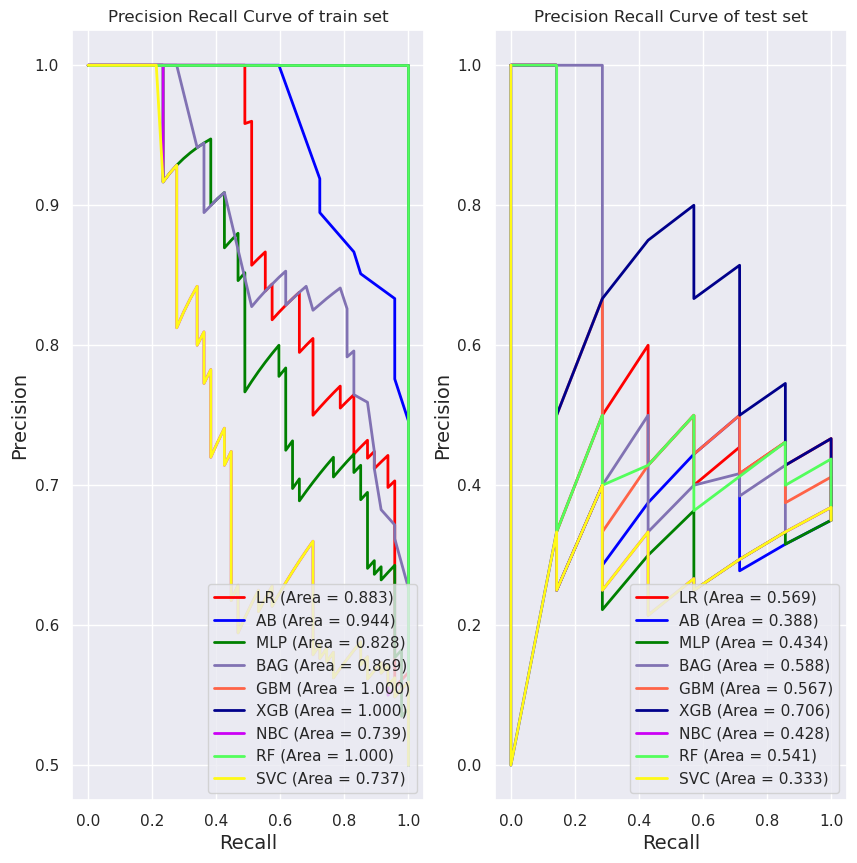

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score
def ro_curve(k,y_pred, y_label, method_name,color,title):
    y_label = np.array(y_label)
    y_pred = np.array(y_pred)    
    lr_precision, lr_recall, _ = precision_recall_curve(y_label, y_pred)    
    plt.figure(k)
    plt.plot(lr_recall, lr_precision, lw = 2, label= method_name + ' (Area = %0.3f)' % average_precision_score(y_label, y_pred),color=color)
    fontsize = 14
    plt.xlabel('Recall', fontsize = fontsize)
    plt.ylabel('Precision', fontsize = fontsize)
    plt.title(title)
    plt.legend(loc='lower right')
fig = plt.gcf()

plt.rcParams["figure.figsize"] = [8,10]
#train 
plt.subplot(1,2,1)
ro_curve(1,lr_model.predict_proba(X_train)[:,1],y_train,'LR','red','Precision Recall Curve of train set')
ro_curve(1,AB_model.predict_proba(X_train)[:,1],y_train,'AB','blue','Precision Recall Curve of train set')
ro_curve(1,mlp_model.predict_proba(X_train)[:,1],y_train,'MLP','green','Precision Recall Curve of train set')
ro_curve(1,Bag_model.predict_proba(X_train)[:,1],y_train,'BAG','m','Precision Recall Curve of train set')
ro_curve(1,gbm_model.predict_proba(X_train)[:,1],y_train,'GBM','tomato','Precision Recall Curve of train set')
ro_curve(1,xgb_model.predict_proba(X_train)[:,1],y_train,'XGB','darkblue','Precision Recall Curve of train set')

ro_curve(1,NBC_model.predict_proba(X_train)[:,1],y_train,'NBC','#cb00f5','Precision Recall Curve of train set')
ro_curve(1,RF_model.predict_proba(X_train)[:,1],y_train,'RF','#53fe5c','Precision Recall Curve of train set')
ro_curve(1,SVC_model.predict_proba(X_train)[:,1],y_train,'SVC','#fff917','Precision Recall Curve of train set')

#test
plt.subplot(1,2,2)
ro_curve(1,lr_model.predict_proba(X_test)[:,1],y_test,'LR','red','Precision Recall Curve of test set')
ro_curve(1,AB_model.predict_proba(X_test)[:,1],y_test,'AB','blue','Precision Recall Curve of test set')
ro_curve(1,mlp_model.predict_proba(X_test)[:,1],y_test,'MLP','green','Precision Recall Curve of test set')
ro_curve(1,Bag_model.predict_proba(X_test)[:,1],y_test,'BAG','m','Precision Recall Curve of test set')
ro_curve(1,gbm_model.predict_proba(X_test)[:,1],y_test,'GBM','tomato','Precision Recall Curve of test set')
ro_curve(1,xgb_model.predict_proba(X_test)[:,1],y_test,'XGB','darkblue','Precision Recall Curve of test set')

ro_curve(1,NBC_model.predict_proba(X_test)[:,1],y_test,'NBC','#cb00f5','Precision Recall Curve of test set')
ro_curve(1,RF_model.predict_proba(X_test)[:,1],y_test,'RF','#53fe5c','Precision Recall Curve of test set')
ro_curve(1,SVC_model.predict_proba(X_test)[:,1],y_test,'SVC','#fff917','Precision Recall Curve of test set')


plt.savefig("训练集-测试集PR曲线.pdf",format = "pdf")
plt.show()

# 训练集-测试集校准曲线

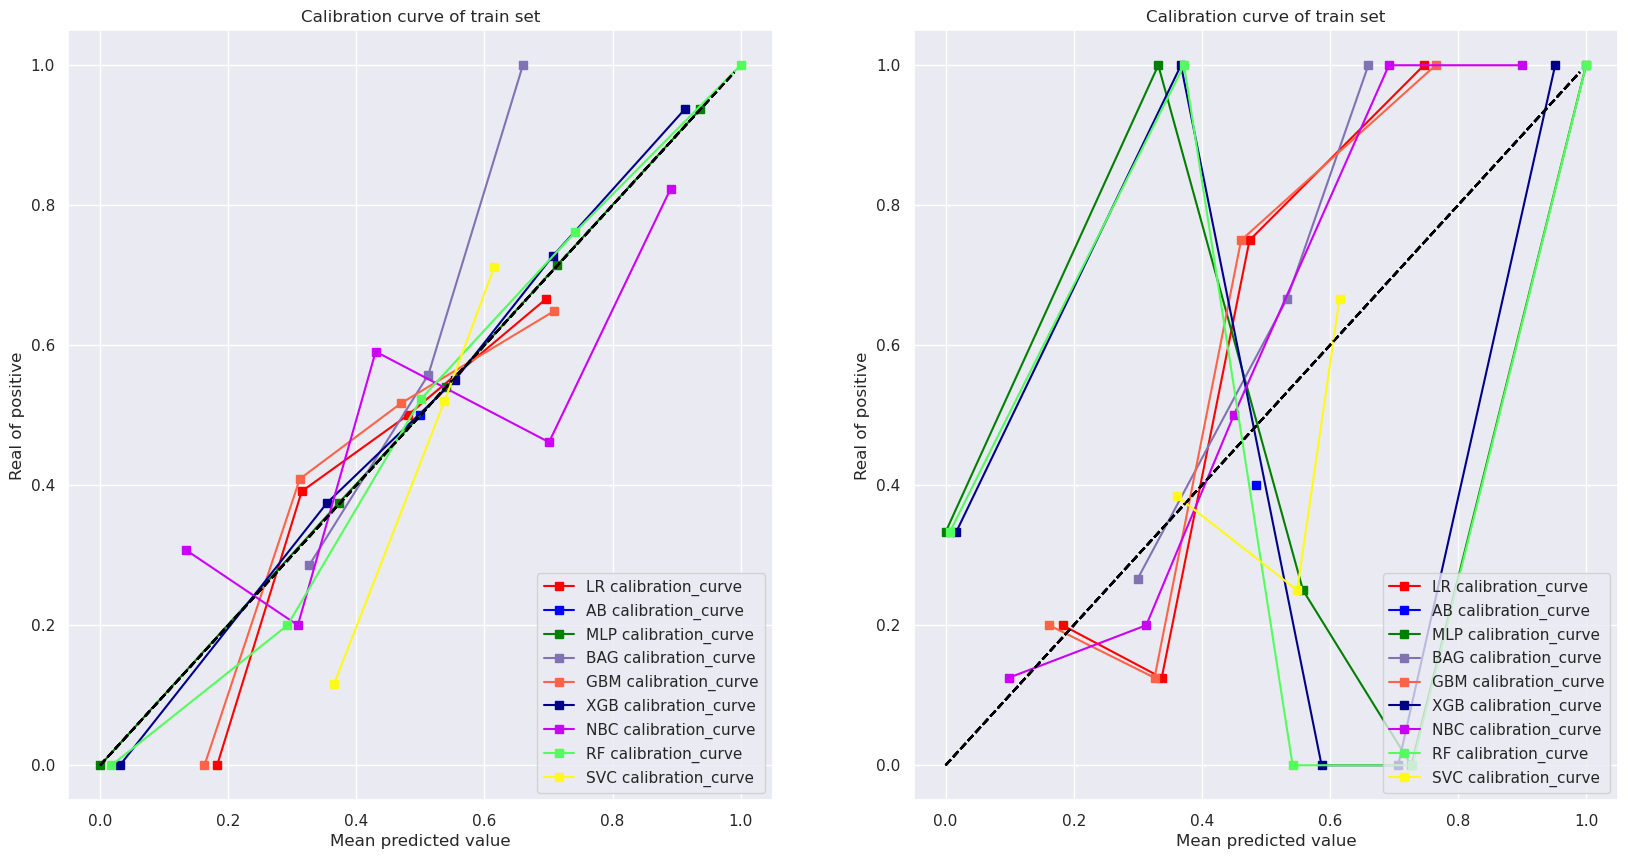

In [12]:
lr_prob = logis_model.predict(X_test)
ab_prob = AB_model.predict(X_test)
mlp_prob = mlp_model.predict(X_test)
bag_prob = Bag_model.predict(X_test)
gbm_prob = gbm_model.predict(X_test)
xgb_prob = xgb_model.predict(X_test)

nbc_prob=NBC_model.predict(X_test)
rf_prob=RF_model.predict(X_test)
svc_prob=SVC_model.predict(X_test)

plt.rcParams["axes.grid"] = False
sns.set()
from sklearn.calibration import calibration_curve
def calibration_curve_1(k,y_pred,y_true,method_name,color,title):
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=5)
    plt.figure(k)
    plt.plot(prob_pred,prob_true,color=color,label='%s calibration_curve'%method_name,marker='s')
    plt.plot([i/100 for i in range(0,100)],[i/100 for i in range(0,100)],color='black',linestyle='--')
    #plt.xlim(-0.02,1.02,0.2)
    #plt.ylim(-0.02,1.02,0.2)
    plt.xlabel('Mean predicted value')
    plt.ylabel('Real of positive')
    plt.title(title)
    plt.legend(loc='lower right')

plt.rcParams["figure.figsize"] = [20, 10]

plt.subplot(1,2,1)
calibration_curve_1(1,lr_model.predict_proba(X_train)[:,1],y_train,'LR','red','Calibration curve of train set')
calibration_curve_1(1,AB_model.predict_proba(X_train)[:,1],y_train,'AB','blue','Calibration curve of train set')
calibration_curve_1(1,mlp_model.predict_proba(X_train)[:,1],y_train,'MLP','green','Calibration curve of train set')
calibration_curve_1(1,Bag_model.predict_proba(X_train)[:,1],y_train,'BAG','m','Calibration curve of train set')
calibration_curve_1(1,gbm_model.predict_proba(X_train)[:,1],y_train,'GBM','tomato','Calibration curve of train set')
calibration_curve_1(1,xgb_model.predict_proba(X_train)[:,1],y_train,'XGB','darkblue','Calibration curve of train set')

calibration_curve_1(1,NBC_model.predict_proba(X_train)[:,1],y_train,'NBC','#cb00f5','Calibration curve of train set')
calibration_curve_1(1,RF_model.predict_proba(X_train)[:,1],y_train,'RF','#53fe5c','Calibration curve of train set')
calibration_curve_1(1,SVC_model.predict_proba(X_train)[:,1],y_train,'SVC','#fff917','Calibration curve of train set')


plt.subplot(1,2,2)
calibration_curve_1(1,lr_model.predict_proba(X_test)[:,1],y_test,'LR','red','Calibration curve of test set')
calibration_curve_1(1,AB_model.predict_proba(X_test)[:,1],y_test,'AB','blue','Calibration curve of test set')
calibration_curve_1(1,mlp_model.predict_proba(X_test)[:,1],y_test,'MLP','green','Calibration curve of test set')
calibration_curve_1(1,Bag_model.predict_proba(X_test)[:,1],y_test,'BAG','m','Calibration curve of test set')
calibration_curve_1(1,gbm_model.predict_proba(X_test)[:,1],y_test,'GBM','tomato','Calibration curve of test set')
calibration_curve_1(1,xgb_model.predict_proba(X_test)[:,1],y_test,'XGB','darkblue','Calibration curve of test set')

calibration_curve_1(1,NBC_model.predict_proba(X_test)[:,1],y_test,'NBC','#cb00f5','Calibration curve of train set')
calibration_curve_1(1,RF_model.predict_proba(X_test)[:,1],y_test,'RF','#53fe5c','Calibration curve of train set')
calibration_curve_1(1,SVC_model.predict_proba(X_test)[:,1],y_test,'SVC','#fff917','Calibration curve of train set')


plt.savefig("训练集-测试集校准曲线.pdf", format="pdf")
plt.show()

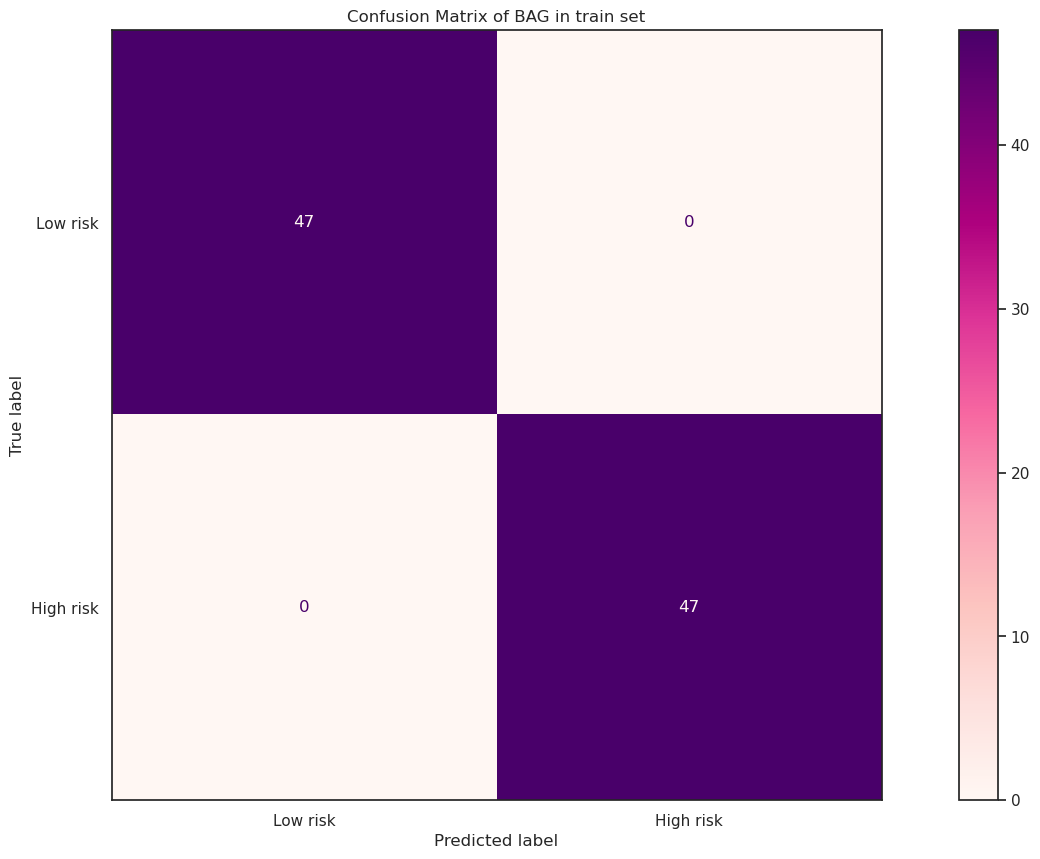

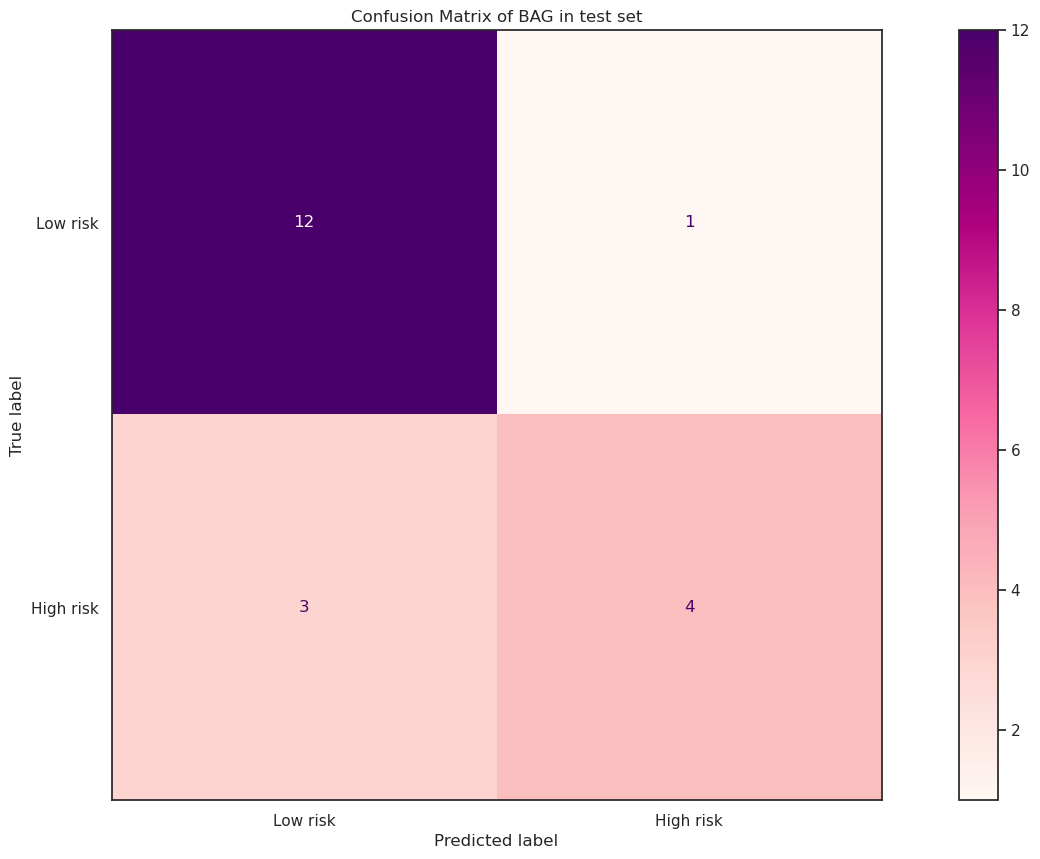

In [38]:
model = RF_model    
  
# 创建一个图形和两个子图  
#训练集
mlp_prob_train = model.predict(X_train)  
cm = confusion_matrix(y_train, mlp_prob_train)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low risk', 'High risk'])  
sns.set_style("white")  
disp.plot(cmap='RdPu') 
plt.title("Confusion Matrix of BAG in train set")
plt.savefig('训练集混淆矩阵.pdf',format='pdf')
plt.show()

#测试集
mlp_prob_test = model.predict(X_test)  
cm = confusion_matrix(y_test, mlp_prob_test)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low risk', 'High risk'])  
sns.set_style("white")  
disp.plot(cmap='RdPu') 
plt.title("Confusion Matrix of BAG in test set")  
plt.savefig('测试集混淆矩阵.pdf',format='pdf') 
plt.show()

# 最佳模型五折ROC曲线

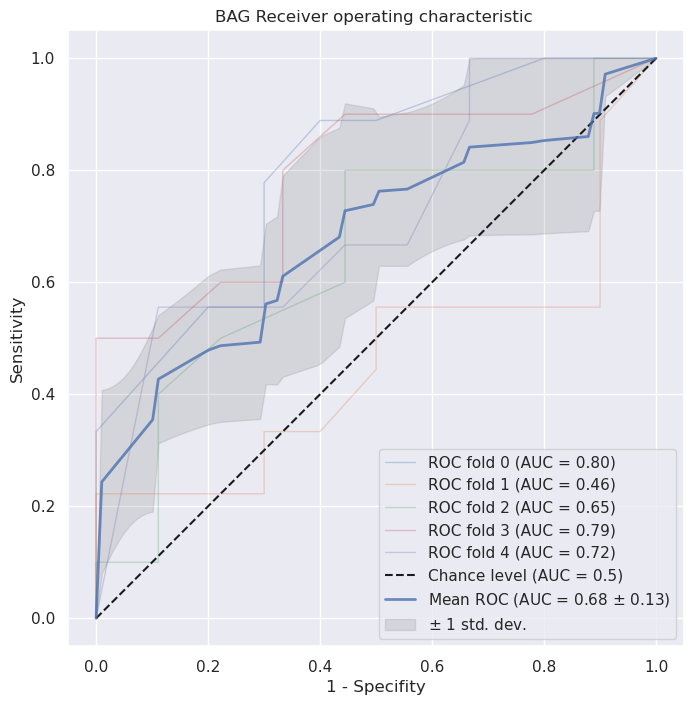

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
sns.set()

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)
classifier = RF_model #修改为性能最优的模型

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X=X_train  #修改为相应的训练集数据
y=y_train

fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="BAG Receiver operating characteristic ", #选择最佳机器学习模型
    # title=f"Mean ROC curve with variability\n(Positive label 'pulmary infection')", 
)
ax.legend(loc="lower right")
plt.xlabel("1 - Specifity")
plt.ylabel("Sensitivity")
plt.savefig('最佳模型五折ROC曲线.pdf',format='pdf')
plt.show()



# 模型在测试集中的性能展示

In [23]:
#可以用classification_report运行来展示模型分类报告

#针对测试集的评价指标矩阵
data_pingjia=pd.DataFrame(index = ['F1','AUC','accuracy','sensitivity','specificity'])  #设置行名
model_name = [AB_model,lr_model,Bag_model,mlp_model,gbm_model,xgb_model,NBC_model,RF_model,SVC_model]

for i in range(len(model_name)):
    #计算F1值
    F1 = f1_score(y_test, model_name[i].predict(X_test), average='macro')
    #计算AUC
    fpr, tpr, thresholds = roc_curve(y_test, model_name[i].predict_proba(X_test)[:, 1])
    AUC = auc(fpr, tpr)
    #计算accuracy
    accuracy = model_name[i].score(X_test,y_test)
    #计算sensitivity和specificity
    TN, FP, FN, TP = confusion_matrix(y_test, model_name[i].predict(X_test)).ravel()
    sensitivity,specificity = round(TP/(TP+FN), 3), round(TN/(FP+TN), 3)
    data_pingjia[i]=[F1,AUC,accuracy,sensitivity,specificity]
data_pingjia.columns = ["AB",'LR','BAG','MLP','GBM','XGB','NBC','RF','SVC']  #修改列名

# data_pingjia
data_pingjia.round(3)#保留小数位数
data_pingjia.T #数据转置


,F1,AUC,accuracy,sensitivity,specificity
AB,0.670330,0.714286,0.70,0.571,0.769
LR,0.761905,0.857143,0.80,0.571,0.923
BAG,0.531250,0.780220,0.70,0.143,1.000
MLP,0.259259,0.285714,0.35,0.000,0.538
GBM,0.715100,0.780220,0.75,0.571,0.846
XGB,0.670330,0.670330,0.70,0.571,0.769
NBC,0.686520,0.736264,0.75,0.429,0.923
RF,0.561129,0.736264,0.65,0.286,0.846
SVC,0.531250,0.637363,0.70,0.143,1.000


In [49]:
data_pingjia

,AB,LR,BAG,MLP,GBM,XGB,NBC,RF,SVC
F1,0.509169,0.488994,0.679803,0.544818,0.509169,0.544818,0.462424,0.512871,0.613095
AUC,0.695000,0.731667,0.793333,0.708333,0.765000,0.718333,0.698333,0.741667,0.771667
accuracy,0.676923,0.692308,0.876923,0.692308,0.676923,0.692308,0.646154,0.646154,0.815385
sensitivity,0.600000,0.400000,0.600000,0.800000,0.600000,0.800000,0.400000,0.800000,0.600000
specificity,0.683000,0.717000,0.900000,0.683000,0.683000,0.683000,0.667000,0.633000,0.833000


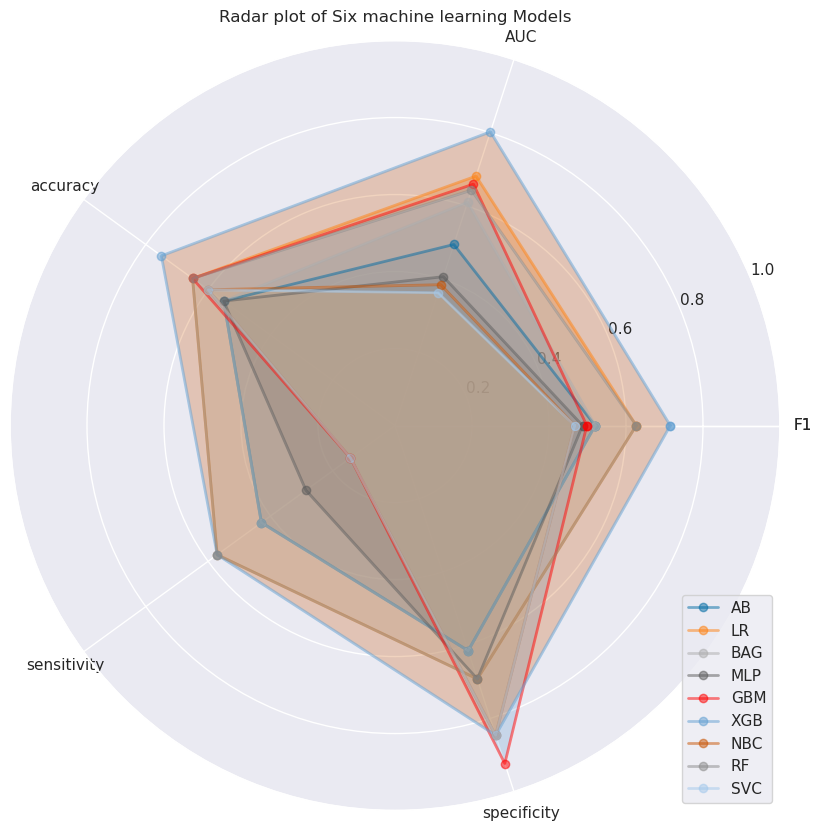

In [17]:
#绘制评价指标雷达图
values = data_pingjia.AB
values1 = data_pingjia.LR
values2 = data_pingjia.BAG
values3 = data_pingjia.MLP
values4 = data_pingjia.GBM
values5 = data_pingjia.XGB

values6 = data_pingjia.NBC
values7 = data_pingjia.RF
values8 = data_pingjia.SVC

S_labels = ['F1','AUC','accuracy','sensitivity','specificity','F1']  #最后一个一定要与第一个重合0和360的问题
# 设置每个数据点的显示位置，在雷达图上用角度表示
angles=np.linspace(0, 2*np.pi,len(values), endpoint=False)  #2*np.pi是2π的意思

# 拼接数据首尾，使图形中线条封闭
values=np.concatenate((values,[values[0]]))
values1=np.concatenate((values1,[values1[0]]))
values2=np.concatenate((values2,[values2[0]]))
values3=np.concatenate((values3,[values3[0]]))
values4=np.concatenate((values4,[values4[0]]))
values5=np.concatenate((values5,[values5[0]]))

values6 = np.concatenate((values6,[values6[0]]))
values7 = np.concatenate((values7,[values7[0]]))
values8 = np.concatenate((values8,[values8[0]]))

angles=np.concatenate((angles,[angles[0]]))

# 绘图
fig=plt.figure()
# 设置为极坐标格式
ax = fig.add_subplot(111, polar=True)
# 绘制折线图
ax.plot(angles, values, 'o-', linewidth=2, alpha=0.5 ,label='AB')
ax.plot(angles, values1, 'o-', linewidth=2, alpha=0.5 ,label='LR')
ax.plot(angles, values2, 'o-', linewidth=2, alpha=0.5 ,label='BAG')
ax.plot(angles, values3, 'o-', linewidth=2, alpha=0.5 ,label='MLP')
ax.plot(angles, values4, 'o-', linewidth=2, alpha=0.5 ,label='GBM',color='red')
ax.plot(angles, values5, 'o-', linewidth=2, alpha=0.5,label='XGB')

ax.plot(angles, values6, 'o-', linewidth=2, alpha=0.5 ,label='NBC')
ax.plot(angles, values7, 'o-', linewidth=2, alpha=0.5 ,label='RF')
ax.plot(angles, values8, 'o-', linewidth=2, alpha=0.5,label='SVC')

# 填充颜色
ax.fill(angles, values, alpha=0.25)
ax.fill(angles, values1, alpha=0.25)
ax.fill(angles, values2, alpha=0.25)
ax.fill(angles, values3, alpha=0.25)
ax.fill(angles, values4, alpha=0.25)
ax.fill(angles, values5, alpha=0.25)

ax.fill(angles, values6, alpha=0.25)
ax.fill(angles, values7, alpha=0.25)
ax.fill(angles, values8, alpha=0.25)
# 设置图标上的角度划分刻度，为每个数据点处添加标签
ax.set_thetagrids(angles * 180/np.pi,labels=S_labels)  #angles * 180/np.pi 将弧度转化为度数
 
# 设置雷达图的范围
ax.set_ylim(0,1)
# 添加标题
plt.title('Radar plot of Six machine learning Models') #Radar plot of Six machine learning Methods
# 添加网格线
ax.grid(True)
plt.legend(loc="lower right")
plt.savefig('模型在测试集中的性能展示-雷达图.pdf',format='pdf')
plt.show()


# 特征重要性SHAP-Perumation

In [59]:
import shap

# 解释器使用 KernelExplainer
explainer = shap.KernelExplainer(Bag_model.predict, X_train)
# 计算 SHAP 值
shap_values = explainer.shap_values(X_train)

  0%|          | 0/94 [00:00<?, ?it/s]

In [13]:
y_train.iloc[150, :]

IndexingError: Too many indexers

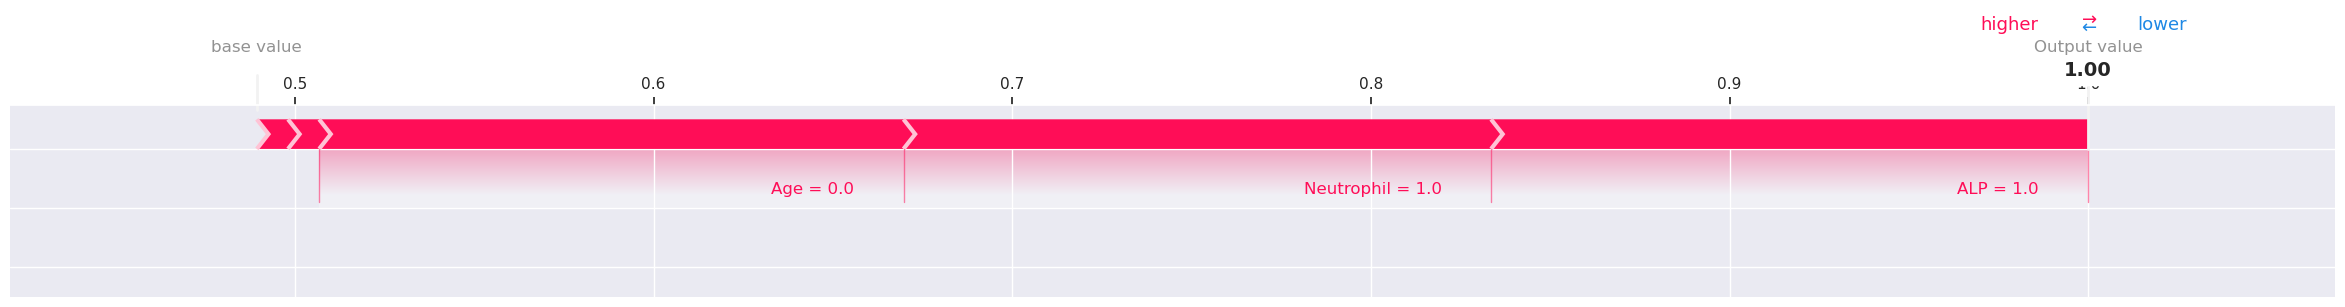

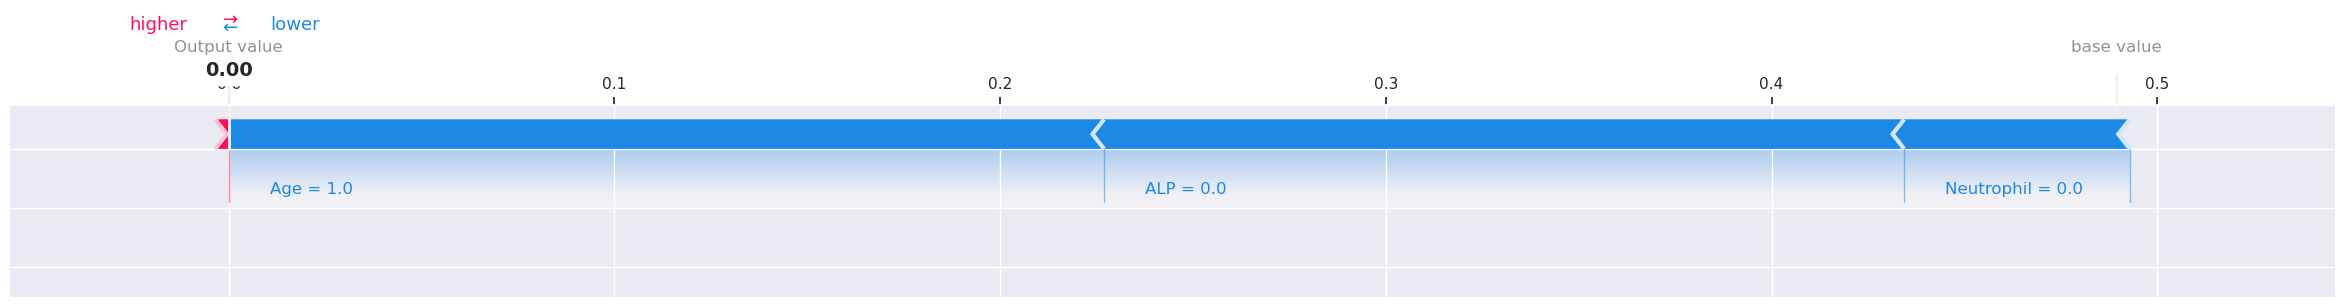

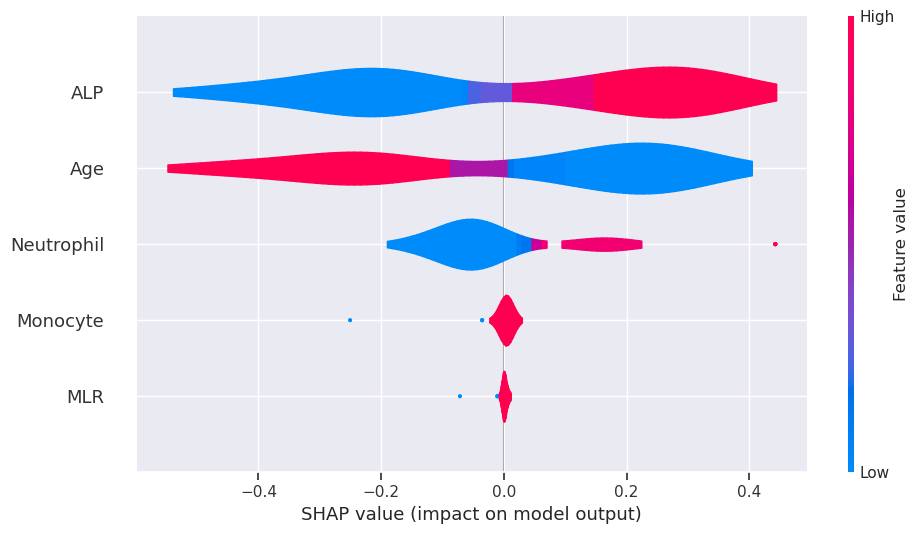

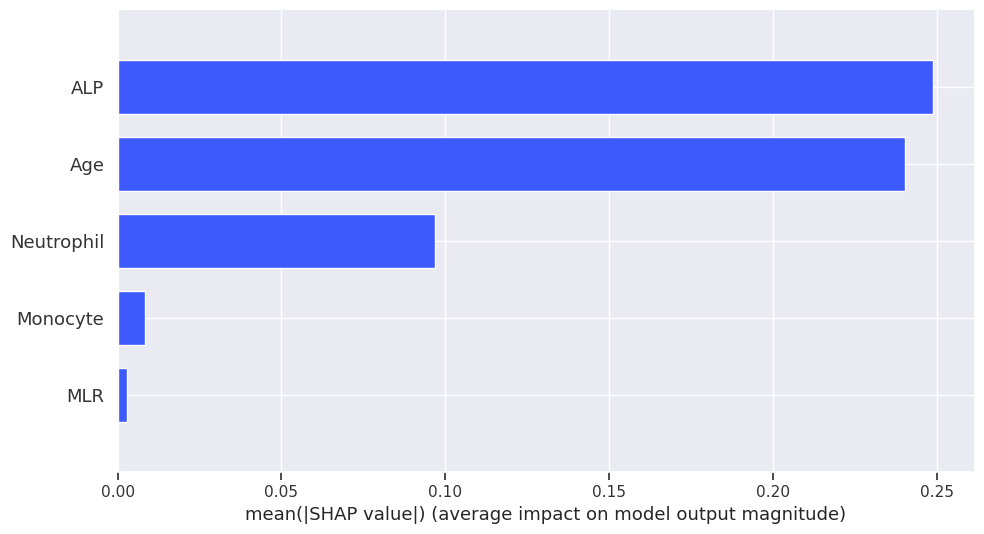

In [61]:


# 可视化第一个预测的 SHAP 值
#shap.force_plot(explainer.expected_value, shap_values[0], X_test[0])
#explainer = shap.Explainer(Mlp_model,X_train)
#shap_values = explainer(X_train)

#吴世楠绘制
#Feature importances1 and 2
a = 80
shap.plots.force(explainer.expected_value,  #shap.force_plot
                shap_values[a],  #表示第 155 个样本的特征对模型输出的影响(低风险强脊)
                X_train.iloc[a, :], 
                figsize=(30, 2.5),
                #link = "logit",
                matplotlib=True,
                out_names = "Output value",show=False)
#plt.rcParams["figure.figsize"] = [30, 5]
plt.savefig('plot1.png',format='png')
plt.show()

a = 20
shap.plots.force(explainer.expected_value,  #shap.force_plot
                shap_values[a], 
                X_train.iloc[a, :], 
                figsize=(30, 2.5),
                # link = "logit",
                matplotlib=True,
                out_names = "Output value",show=False)
#plt.rcParams["figure.figsize"] = [30, 10]
plt.savefig('plot2.pdf',format='pdf')
plt.show()

#Feature importances(吴世楠)
#violin
shap.summary_plot(shap_values, 
                  X_train,
                  plot_type="violin", 
                  max_display=10,
                  color='#3d5afe',
                  title='Feature importance',show=False,plot_size=(10,5.5))
# plt.title("Feature importance")
plt.savefig('violin.pdf',format='pdf')
plt.show()

#bar
shap.summary_plot(shap_values, 
                  X_train, 
                  plot_type="bar", 
                  color='#3d5afe',
                  title='Feature importance',max_display=10,show=False,plot_size=(10,5.5))
# plt.title("Feature importance")
plt.savefig('bar.pdf',format='pdf')
plt.show()

# ##Feature importances(刘文彩)
# shap.bar_plot(shap_values, features=None, feature_names=None, max_display=10, show=False)
# plt.title("Feature importance")
# plt.show()

In [62]:
result = permutation_importance(AB_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result1 = permutation_importance(lr_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result2= permutation_importance(Bag_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result3 = permutation_importance(mlp_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result4 = permutation_importance(gbm_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result5 = permutation_importance(xgb_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result6 = permutation_importance(NBC_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result7 = permutation_importance(RF_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result8 = permutation_importance(SVC_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')


plt.rcParams["figure.figsize"] = [30, 15]
features = X.columns

plt.subplot(331)
r_feat_imp = pd.Series(abs(100*(result.importances_mean)/result.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of AB',color='#5fc9f8')
# 只取前15个最重要的特征  
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True) 
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of AB',color='#5fc9f8')


plt.subplot(332)
r_feat_imp = pd.Series(abs(100*result1.importances_mean/result1.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of LR',color='#fecb2e')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of LR',color='#fecb2e')

plt.subplot(333)
r_feat_imp = pd.Series(abs(100*result2.importances_mean/result2.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of BAG',color='#fd9426')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of BAG',color='#fd9426')

plt.subplot(334)
r_feat_imp = pd.Series(abs(100*result3.importances_mean/result3.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of MLP',color='#fc3158')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of MLP',color='#fc3158')

plt.subplot(335)
r_feat_imp = pd.Series(abs(100*result4.importances_mean/result4.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of GBM',color='#147efb')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of GBM',color='#147efb')

plt.subplot(336)
r_feat_imp = pd.Series(abs(100*result5.importances_mean/result5.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of XGB',color='#53d769')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of XGB',color='#53d769')

plt.subplot(337)
r_feat_imp = pd.Series(abs(100*result6.importances_mean/result5.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of XGB',color='#53d769')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of NBC',color='#cb00f5')

plt.subplot(338)
r_feat_imp = pd.Series(abs(100*result7.importances_mean/result5.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of XGB',color='#53d769')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of RF',color='#53fe5c')

plt.subplot(339)
r_feat_imp = pd.Series(abs(100*result8.importances_mean/result5.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of XGB',color='#53d769')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of SVC',color='#fff917')

plt.savefig('feature_importances.pdf', format='pdf')  

plt.close()


# 模型导出

In [65]:
import joblib

# 将模型保存为文件
joblib.dump(Bag_model,'Bag_model.pkl')

['Bag_model.pkl']

In [24]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

# 加载模型
model = joblib.load('xgb_model.pkl')

# 定义预测接口
@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    features = data['features']
    prediction = model.predict(features)
    return jsonify({'prediction': prediction.tolist()})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (inotify)
Traceback (most recent call last):
  File "/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
  File "/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 692, in initialize
    self.init_sockets()
  File "/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 331, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)
  File "/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/ipyke

SystemExit: 1

/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
